In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Hermes IO

In [2]:
casestore = dict()

In [3]:
db = CaseDB()

toload = [
    # dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="2e19_free", id="d12a-2e19_free_sol", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="2e19_decay", id="d13a-d11b_decaylength", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="base", id="d14br-rerun_latest_edgerecycling", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]


(-0.87, 0.0)

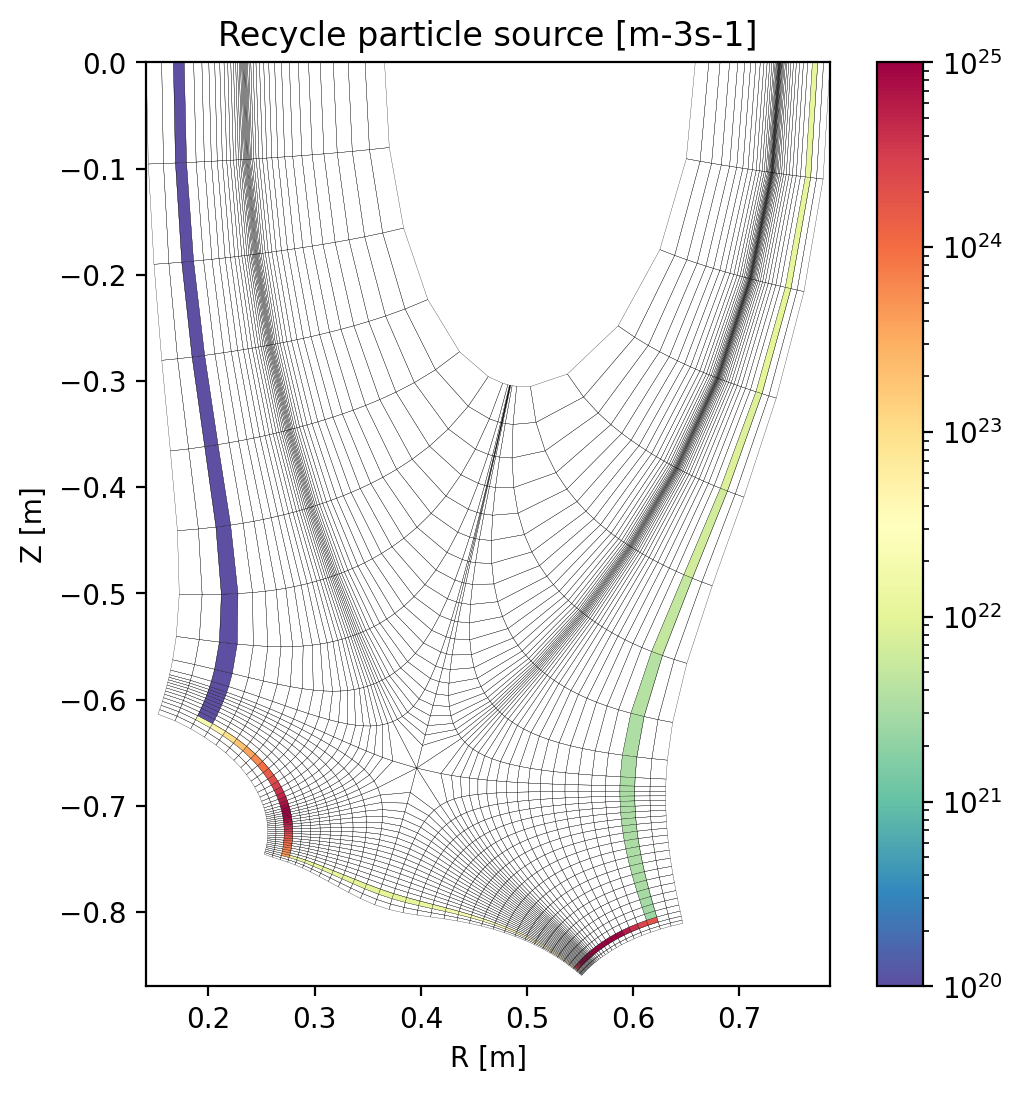

In [17]:
fig, ax = plt.subplots(dpi = 200, figsize = (6,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["base"].ds
m = ds.metadata
da = ds["Sd_sol_recycle"] + ds["Sd_pfr_recycle"] + ds["Sd_target_recycle"]
da.hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True, vmin = 1e20, vmax = 1e25, linewidth=0.1, separatrix = False)

ax.set_title("Recycle particle source [m-3s-1]")
ax.set_aspect("equal")
ax.set_ylim(-0.87, 0)

In [4]:
plt.close("all")
%matplotlib inline

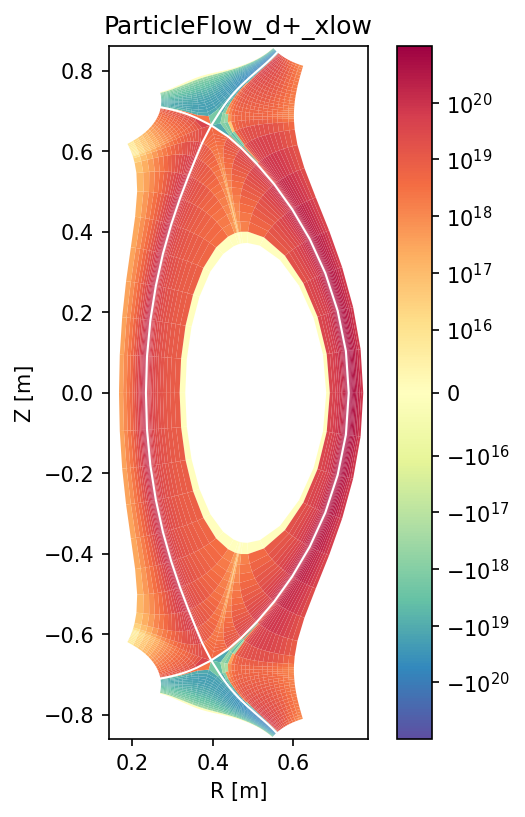

In [5]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["base"].ds
m = ds.metadata
# hermesm.clean_guards().
(ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e21, vmax = 1e21, logscale = True)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True)

ax.set_aspect("equal")
# ax.set_ylim(-0.87, 0)

In [8]:
%matplotlib widget

(-0.87, 0.0)

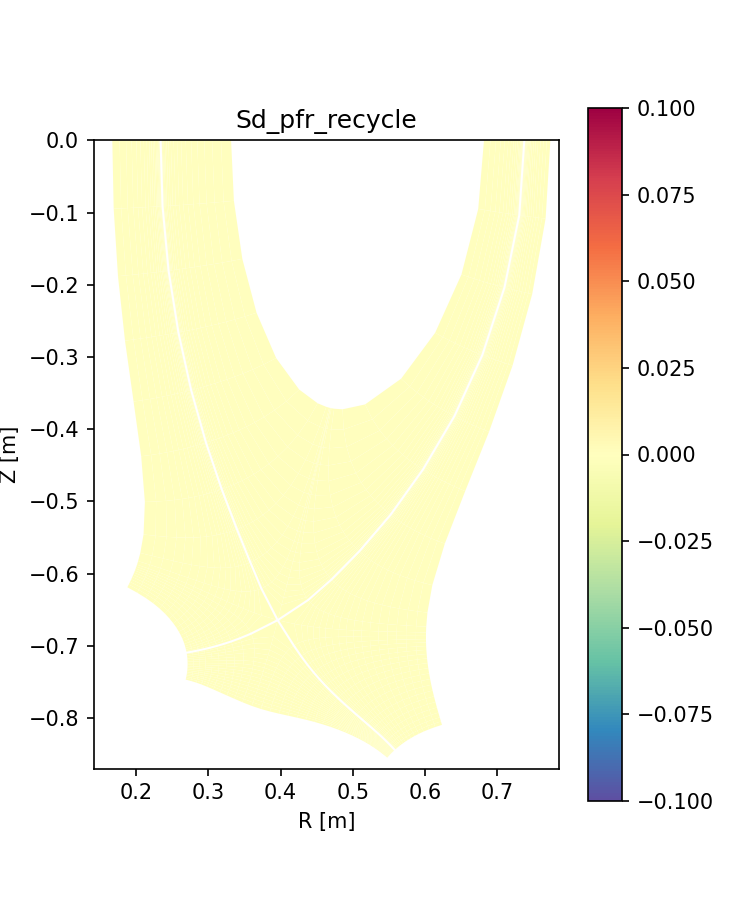

In [10]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
# (ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e4, vmax = 1e4, logscale = True)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True, vmin = 0.1e18, vmax = 2.5e18)
(ds["Sd_pfr_recycle"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = False, vmin = None, vmax = None)

ax.set_aspect("equal")
ax.set_ylim(-0.87, 0)

In [13]:
plt.close("all")
%matplotlib inline

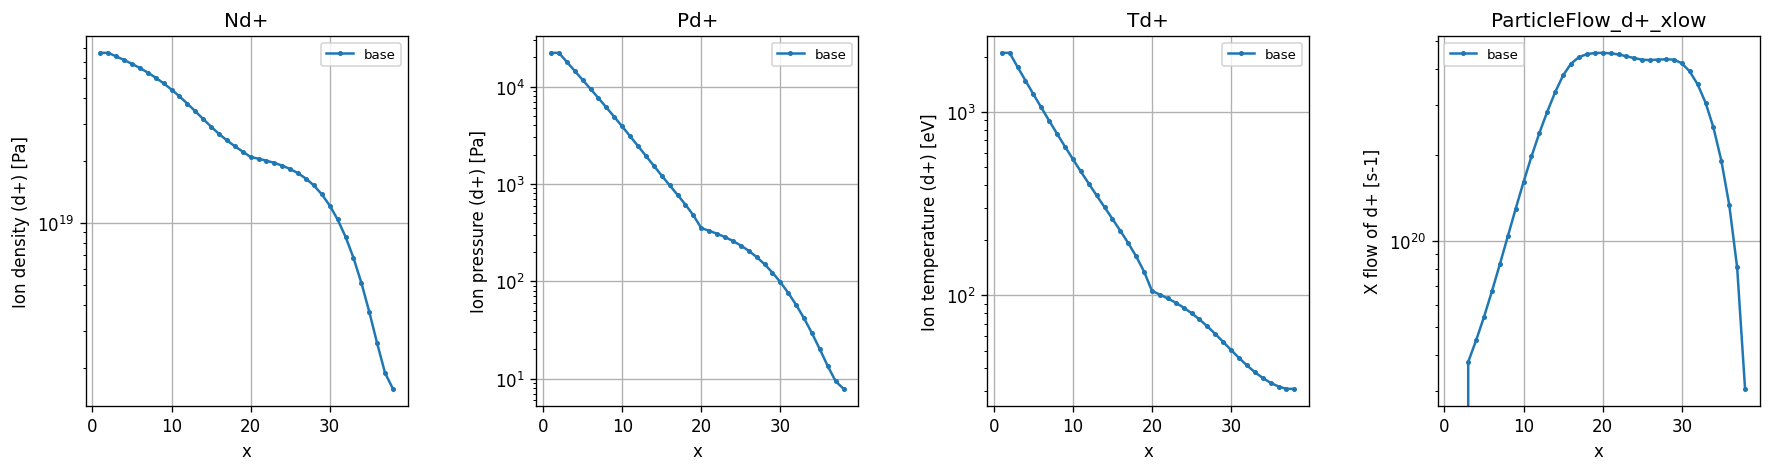

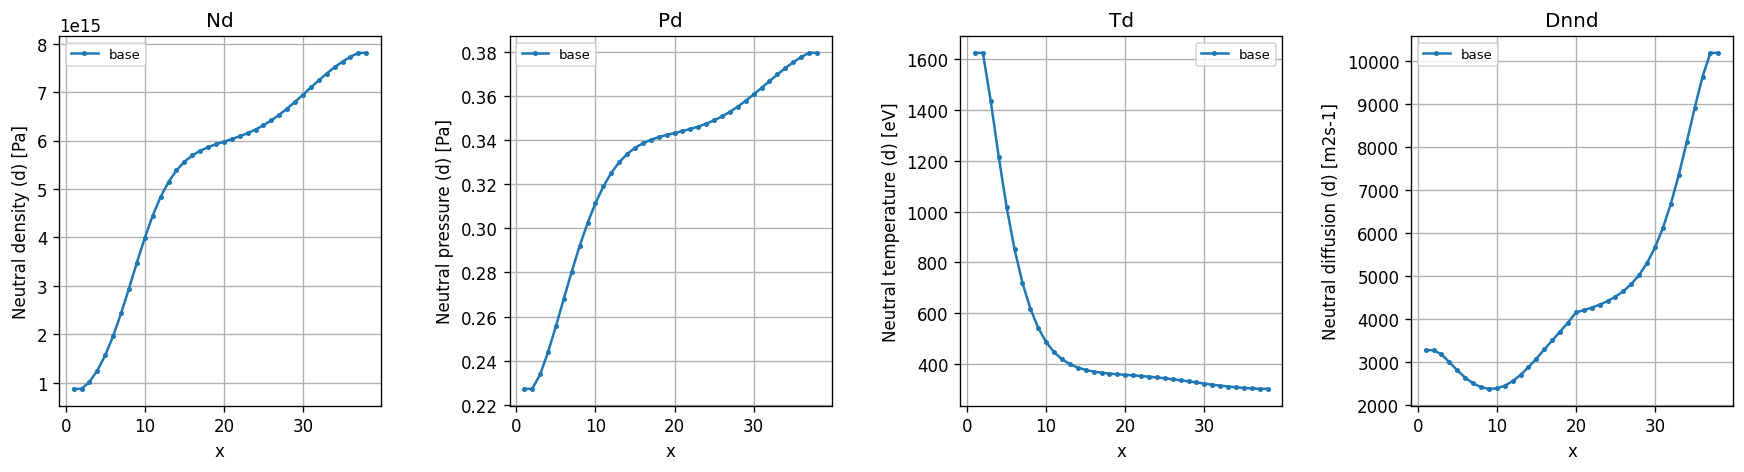

In [15]:
def plot(params):

    fig, axes = plt.subplots(1,len(params), figsize=(4.5*len(params),4), dpi=120)
    fig.subplots_adjust(wspace = 0.4)

    for i, param in enumerate(params):
        for casename in casestore:
            ds = casestore[casename].ds.isel( x = slice(1,-1))
            omp = ds.hermesm.select_region("outer_midplane_a")

            (omp[param]).plot(ax = axes[i], marker = "o", label = casename, ms = 2)
            
            if omp[param].max()/omp[param].min() > 10:
                axes[i].set_yscale("log")
        axes[i].grid()
        axes[i].set_title(param)
        axes[i].legend(fontsize = 8)
   

plot(["Nd+", "Pd+", "Td+", "ParticleFlow_d+_xlow"])   
plot(["Nd", "Pd", "Td", "Dnnd"])  
# plot(["Nd", "Pd"])


# Manual flux calcs

In [4]:
ds = casestore["base"].ds#.isel(t=-1)
m = ds.metadata

core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
sol_guards = ds.hermesm.select_region("sol_edge_inner_guards")

domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_noy = ds.hermesm.select_region("all_no_y_guards").squeeze()
domain_volume = domain["dv"].values.sum()

Pnorm = m["Nnorm"] * m["Tnorm"] * constants("q_e")
# nfluxnorm =  (m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"])
# efluxnorm =  (m["rho_s0"] * m["rho_s0"]**2 * Pnorm * m["Omega_ci"])   # W
# nsourcenorm = (m["Nnorm"] * m["Omega_ci"])
# esourcenorm = (Pnorm * m["Omega_ci"]) 

# Let's test normalisations in  Load
nsourcenorm = 1
esourcenorm = 1
efluxnorm = 1
nfluxnorm = 1

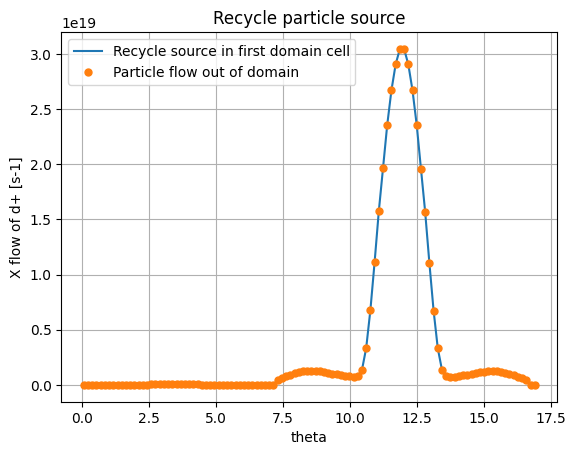

In [5]:
(ds["Sd_sol_recycle"].isel(x=-3) * nsourcenorm * ds["dv"].isel(x=-3)).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm).plot(label = "Particle flow out of domain", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle particle source")
plt.grid()
# plt.yscale("log")
# ds["Sd_target_recycle"].isel(x=-3).plot()

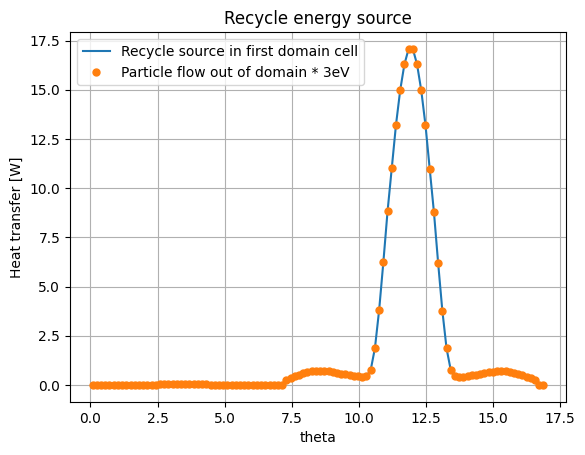

In [29]:
(ds["Ed_sol_recycle"].isel(x=-3) * esourcenorm * ds["dv"].isel(x=-3)).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm * 3.5 * constants("q_e")).plot(label = "Particle flow out of domain * 3eV", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle energy source")
plt.ylabel("Heat transfer [W]")
plt.grid()
# plt.yscale("log")
# ds["Sd_target_recycle"].isel(x=-3).plot()

## Targets

In [32]:
ds = calculate_target_fluxes(ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


Total target ion particle flux: 6.940e+22
Total target recycle source: 7.131e+22


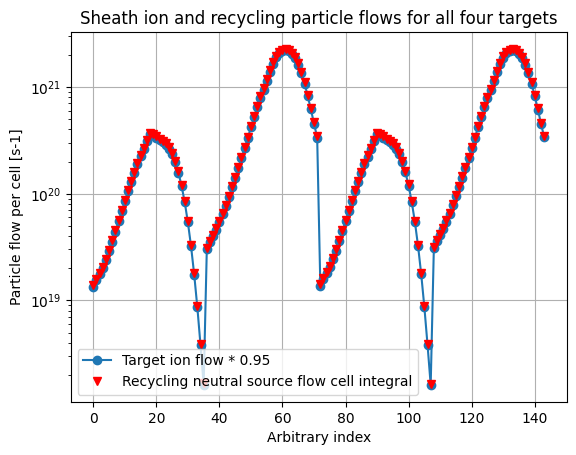

In [33]:
fig, ax = plt.subplots()
frecycle = 0.95

fluxes = []
recycle = []
for name in m["targets"]:
    target = ds.hermesm.select_region(f"{name}_target")
    recycle.append(target["Sd_target_recycle"].values * target["dv"].values * nsourcenorm)
    fluxes.append(ds[f"pf_{name}_target_d+"].isel(x=slice(2,-2)).values * -1 * frecycle)
fluxes = np.concatenate(fluxes)
recycle = np.concatenate(recycle)
ax.plot(fluxes, marker = "o", label = "Target ion flow * 0.95")
ax.plot(recycle, marker = "v", lw = 0, color = "r", label = "Recycling neutral source flow cell integral")
ax.legend()
ax.set_yscale("log")

tflux_ions = np.sum(fluxes)
tflux_recycle = np.sum(recycle)
print(f"Total target ion particle flux: {tflux_ions:.3e}")
print(f"Total target recycle source: {tflux_recycle:.3e}")
ax.set_xlabel("Arbitrary index")
ax.set_ylabel("Particle flow per cell [s-1]")
ax.set_title("Sheath ion and recycling particle flows for all four targets")
ax.grid()
# target["x"].values

## PFR

Total PFR ion particle flux: -1.046e+20
Total PFR recycle source: 1.046e+20


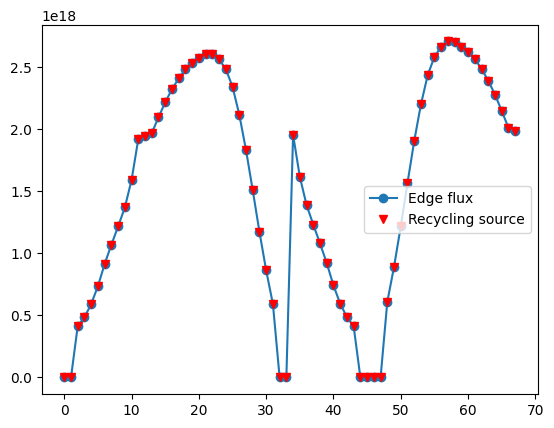

In [6]:
fluxes = []
sources = []
tflux_ions = 0
tflux_recycle = 0

for name in ["lower_pfr_edge", "upper_pfr_edge"]:
    pfr_edge = ds.hermesm.select_region(name)
    fluxes.append((pfr_edge["ParticleFlow_d+_xlow"] * nfluxnorm * -1).squeeze().values)
    sources.append((pfr_edge["Sd_pfr_recycle"] * nsourcenorm * ds["dv"]).squeeze().values)
    
    tflux_ions += (pfr_edge["ParticleFlow_d+_xlow"] * nfluxnorm).values.sum()
    tflux_recycle += (pfr_edge["Sd_pfr_recycle"] * nsourcenorm * pfr_edge["dv"]).values.sum()
    
print(f"Total PFR ion particle flux: {tflux_ions:.3e}")
print(f"Total PFR recycle source: {tflux_recycle:.3e}")
fluxes = np.concatenate(fluxes)
sources = np.concatenate(sources)

fig, ax = plt.subplots()
ax.plot(fluxes, marker = "o", label = "Edge flux")
ax.plot(sources, lw = 0, marker = "v", label = "Recycling source", c = "r")
ax.legend()
# (ds["ParticleFlow_d+_xlow"].isel(x=2) * nfluxnorm * -1).plot(label = "L flow in inner guard cell into domain", lw = 0, marker = "o", ms = 5)
# plt.legend()
# plt.title("Recycle particle source")
# plt.grid()
# # ds["Sd_target_recycle"].isel(x=-3).plot()